In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os

In [5]:
# Load client CSVs
client1 = pd.read_csv('../../data/client_1_data_V2.csv')
client2 = pd.read_csv('../../data/client_2_data_V2.csv')
client3 = pd.read_csv('../../data/client_3_data_V2.csv')

# Concatenate all clients
df = pd.concat([client1, client2, client3], axis=0).reset_index(drop=True)

In [7]:
print(df.columns)

Index(['Heart_Rate_(bpm)', 'Skin_Conductance', 'Emotion', 'Emotion_Mapped'], dtype='object')


In [8]:
X = df.drop(columns=["Emotion", "Emotion_Mapped"]).values.astype("float32")
y = df["Emotion_Mapped"].values.astype("int64")

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Torch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_val_tensor   = torch.tensor(X_val)
y_val_tensor   = torch.tensor(y_val)

# Dataloaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)


In [9]:
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden=64, n_classes=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, n_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(d_in=X.shape[1]).to(device)


In [10]:
epochs = 20
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_accs, val_accs = [], []

for epoch in range(1, epochs + 1):
    model.train()
    y_true, y_pred = [], []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(logits.argmax(1).cpu().numpy())

    train_acc = accuracy_score(y_true, y_pred)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            y_val_true.extend(yb.cpu().numpy())
            y_val_pred.extend(logits.argmax(1).cpu().numpy())

    val_acc = accuracy_score(y_val_true, y_val_pred)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}")


Epoch 01 | Train Acc: 0.21 | Val Acc: 0.23
Epoch 02 | Train Acc: 0.22 | Val Acc: 0.14
Epoch 03 | Train Acc: 0.26 | Val Acc: 0.24
Epoch 04 | Train Acc: 0.29 | Val Acc: 0.29
Epoch 05 | Train Acc: 0.34 | Val Acc: 0.33
Epoch 06 | Train Acc: 0.39 | Val Acc: 0.46
Epoch 07 | Train Acc: 0.43 | Val Acc: 0.38
Epoch 08 | Train Acc: 0.44 | Val Acc: 0.51
Epoch 09 | Train Acc: 0.49 | Val Acc: 0.53
Epoch 10 | Train Acc: 0.52 | Val Acc: 0.60
Epoch 11 | Train Acc: 0.57 | Val Acc: 0.59
Epoch 12 | Train Acc: 0.57 | Val Acc: 0.62
Epoch 13 | Train Acc: 0.59 | Val Acc: 0.54
Epoch 14 | Train Acc: 0.58 | Val Acc: 0.51
Epoch 15 | Train Acc: 0.60 | Val Acc: 0.62
Epoch 16 | Train Acc: 0.62 | Val Acc: 0.60
Epoch 17 | Train Acc: 0.63 | Val Acc: 0.64
Epoch 18 | Train Acc: 0.65 | Val Acc: 0.63
Epoch 19 | Train Acc: 0.61 | Val Acc: 0.70
Epoch 20 | Train Acc: 0.64 | Val Acc: 0.69


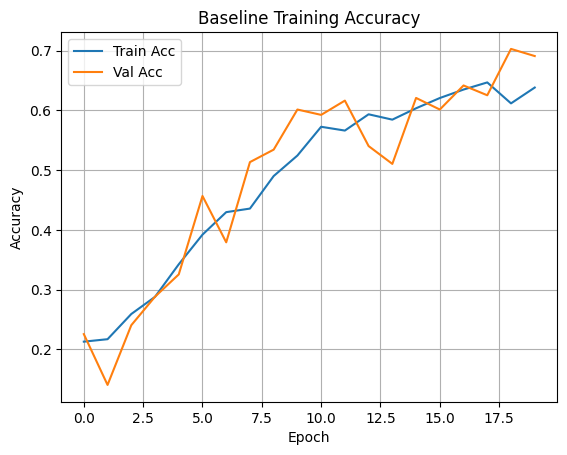

In [11]:
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Baseline Training Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
os.makedirs("../../../results/baseline", exist_ok=True)
torch.save(model.state_dict(), "../../../results/baseline/baseline_model.pth")